<a href="https://colab.research.google.com/github/marianaufcg/Capacitacao/blob/main/C%C3%B3pia_de_a06_4_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Build RIB

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import diags, eye, kron, bmat, csr_matrix
from scipy.sparse.linalg import eigs

def mround(x):
    """
    Arredondamento no estilo MATLAB: .5 -> sobe.
    Aceita escalar ou array NumPy.
    """
    return np.floor(x + 0.5).astype(int)

def diff_opr(Nx,Ny,dx,dy):
  M = Nx*Ny
  diagonal = np.ones(M-1)
  diagonal[Nx-1:-1:Nx] = 0
  Dxf = -sp.eye(M,M) + sp.diags(diagonal, 1, shape=(M,M))
  Dyf = sp.eye(M,M,k = Nx) - sp.eye(M,M)
  Dxg = -Dxf.conj().T
  Dyg = -Dyf.conj().T
  return Dxf/dx, Dyf/dy, Dxg/dx, Dyg/dy

micrometers = 1e-6

# lambda reference
lam0 = 1.55 * micrometers

# number of modes
nmodes = 3

In [ ]:
# Rib material
rib_n1 = 1.0
rib_n2 = 3.5
rib_n3 = 1.5

# Rib dimension
rib_h  = 0.60 * micrometers
rib_t  = 0.60 * micrometers
rib_w  = 0.80 * micrometers

# Extra space
SPACER = lam0 * np.array([1.5, 1.5, 0.5, 0.5])  # [sx_left, sx_right, sy_bottom, sy_top]

### Resolução por comprimento de onda.

In [ ]:
# Grid parameters
nmax   = max(rib_n1, rib_n2, rib_n3)
NRES   = 20

In [ ]:
dx = lam0 / nmax / NRES
dy = lam0 / nmax / NRES
print("dx = %.5e - dy = %.5e"%(dx, dy))

dx = 2.21429e-08 - dy = 2.21429e-08


### Cálculo da malha

In [ ]:
# Adjust mesh
nx = int(np.ceil(rib_w / dx))
dx = rib_w / nx
ny = int(np.ceil(rib_t / dy))
dy = rib_t / ny
print("nx = %d - ny = %d"%(nx, ny))
print("dx = %.5e - dy = %.5e"%(dx, dy))

nx = 37 - ny = 28
dx = 2.16216e-08 - dy = 2.14286e-08


In [ ]:
# Grid size X
Sx = SPACER[0] + rib_w + SPACER[1]
Nx = int(np.ceil(Sx / dx))
Sx = Nx * dx

# Grid size Y
Sy = SPACER[2] + rib_h + rib_t + SPACER[3]
Ny = int(np.ceil(Sy / dy))
Sy = Ny * dy
print("Total size (Nx x Ny) = %d x %d"%(Nx,Ny))
print("Total size (Sx x Sy) = %.3g [um] x %.3g [um]"%(1e6*Sx,1e6*Sy))

# Grid - upsample (2x)
Nx2 = 2 * Nx; dx2 = dx / 2
Ny2 = 2 * Ny; dy2 = dy / 2

# Grid axes
xa  = np.arange(1, Nx + 1) * dx;  xa  = xa  - xa.mean()
ya  = np.arange(1, Ny + 1) * dy;  ya  = ya  - ya.mean()

# Upsample grid (2x)
xa2 = np.arange(1, Nx2 + 1) * dx2; xa2 = xa2 - xa2.mean()
ya2 = np.arange(1, Ny2 + 1) * dy2; ya2 = ya2 - ya2.mean()

# Create meshgrid
Yc, Xc = np.meshgrid(ya2, xa2, indexing="xy")

Total size (Nx x Ny) = 253 x 129
Total size (Sx x Sy) = 5.47 [um] x 2.76 [um]


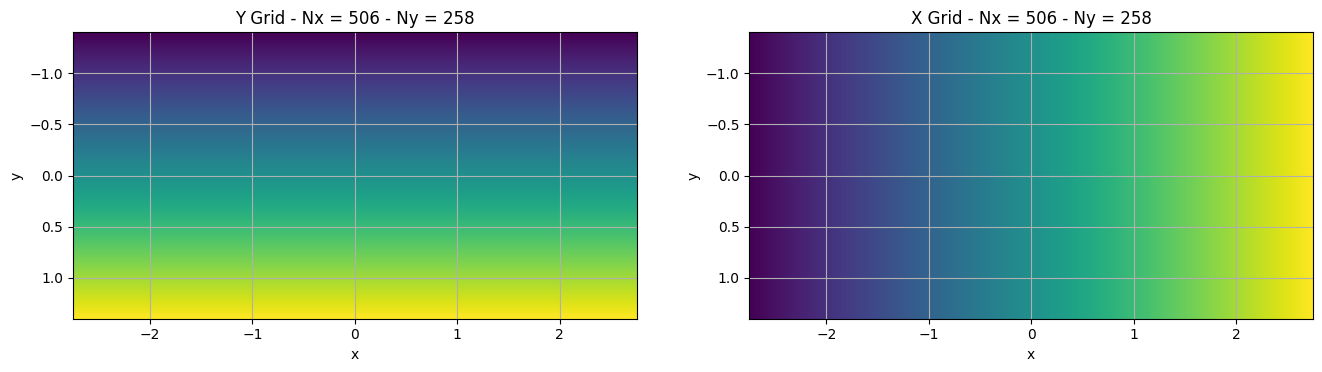

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))

ext = 1e6*np.array([xa2.min()-dx, xa2.max()+dx, ya2.max()+dy, ya2.min()-dy])

ax[0].imshow(Yc.T, extent=ext, aspect="equal")
ax[0].set(xlabel="x", ylabel="y", title=f"{"Y Grid"} - Nx = {Nx2} - Ny = {Ny2}")
ax[0].grid()

ax[1].imshow(Xc.T, extent=ext, aspect="equal")
ax[1].set(xlabel="x", ylabel="y", title=f"{"X Grid"} - Nx = {Nx2} - Ny = {Ny2}")
ax[1].grid()

plt.show()
plt.tight_layout()

### Build device

In [ ]:
# Create matrices
ER2 = (rib_n1**2) * np.ones((Nx2, Ny2))
UR2 = np.ones((Nx2, Ny2))

# Create indexes
nx1 = int(mround(SPACER[0] / dx2))                          # início do núcleo em x
nx2i = nx1 + int(mround(rib_w / dx2))                       # fim exclusivo

ny1 = int(mround(SPACER[2] / dy2))                          # início do “buried oxide”/substrato
ny2i = ny1 + int(mround(rib_h / dy2))                       # topo do “rib” (fim exclusivo)
ny3 = ny2i                                                  # início da “slab”
ny4i = ny3 + int(mround(rib_t / dy2))                       # fim exclusivo da slab
ny5 = ny4i                                                  # início da supercamada (cladding superior)

In [ ]:
# Create RIB waveguide
# Rib (núcleo) na região do “rib” (altura rib_h) limitado à largura rib_w
ER2[nx1:nx2i, ny1:ny2i] = rib_n2**2
# Slab (estende-se por toda a largura)
ER2[:, ny3:ny4i] = rib_n2**2
# Superstrato
ER2[:, ny5:Ny2] = rib_n3**2

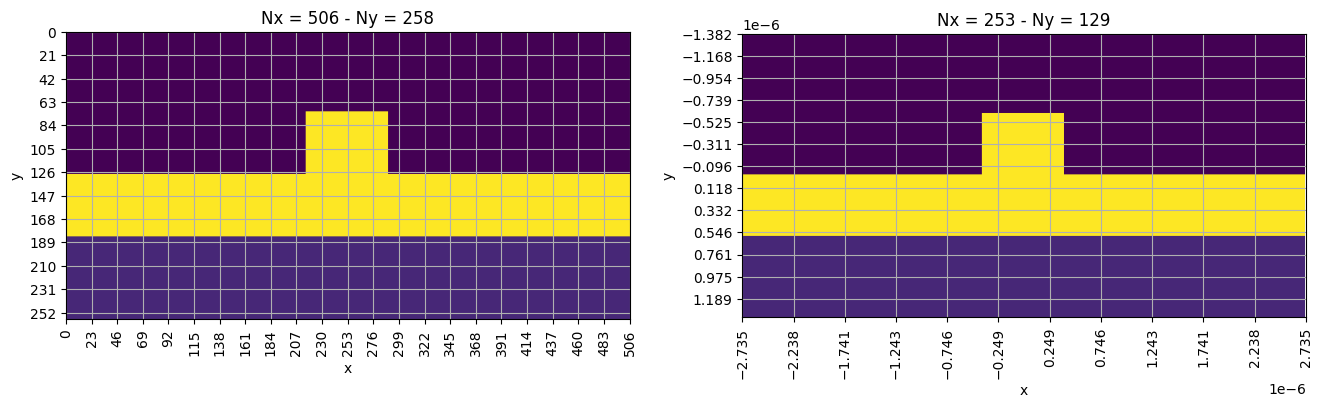

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16, 8))

ax[0].imshow(ER2.T, extent=[0, Nx2, Ny2, 0], aspect="equal")
ax[0].set(xlabel="x", ylabel="y", title=f"Nx = {Nx2} - Ny = {Ny2}")
ax[0].set_xticks(np.arange(0, Nx2 + 1, 23))
ax[0].set_yticks(np.arange(0, Ny2 + 1, 21))
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].grid(which='both')

ax[1].imshow(ER2.T, extent=np.array([xa.min(), xa.max(), ya.max(), ya.min()]), aspect="equal")
ax[1].set(xlabel="x", ylabel="y", title=f"Nx = {Nx} - Ny = {Ny}")
ax[1].set_xticks(np.arange(xa.min()-dx/2, xa.max()+dx, 23*dx))
ax[1].set_yticks(np.arange(ya.min()-dy/2, ya.max()+dy, 10*dy))
#ax[1].plot(Xc.ravel(), Yc.ravel(), marker="o", linestyle="None", markersize=2)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].grid(which='both')

plt.show()
plt.tight_layout()

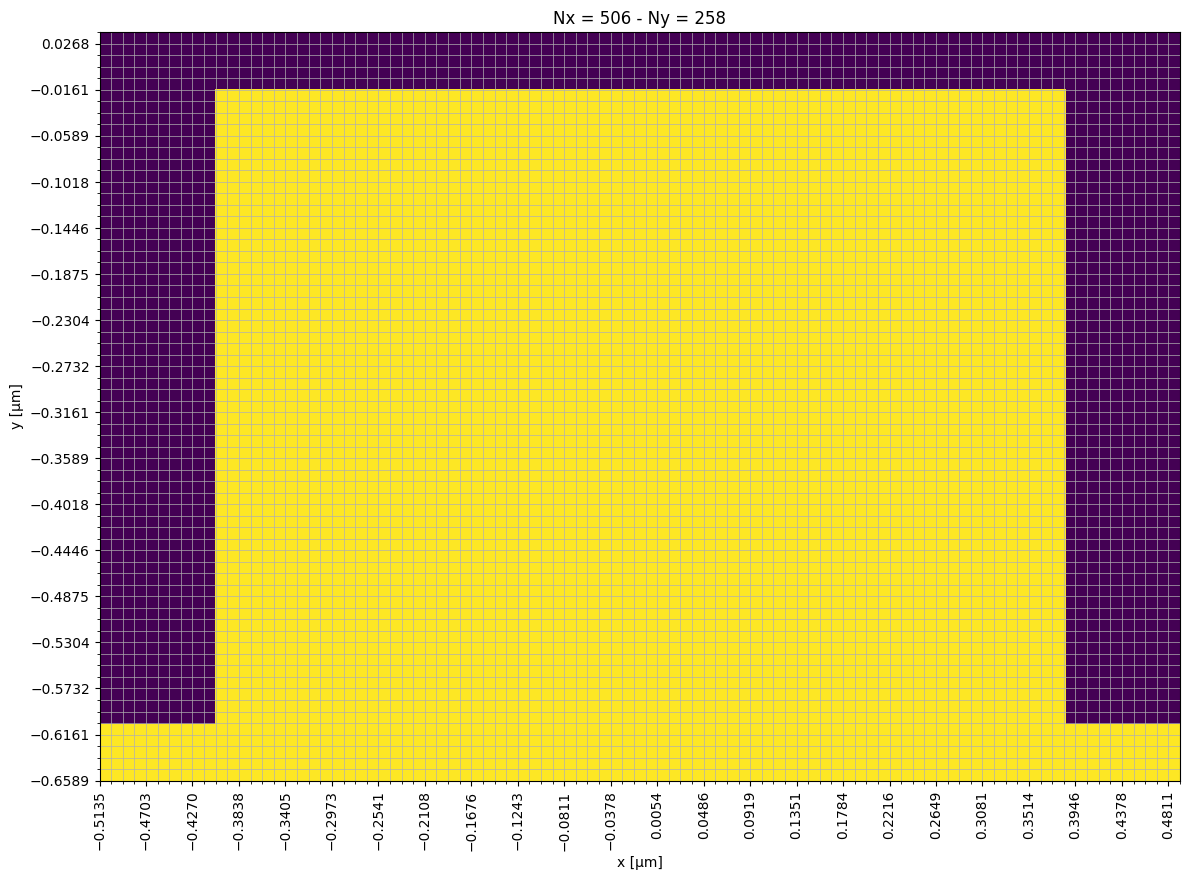

In [ ]:
from matplotlib.ticker import ScalarFormatter

zoomx = 10
zoomy = 5
x_zoom = 1e6*xa2[(nx1-zoomx):(nx2i+zoomx)]
y_zoom = 1e6*ya2[(ny1-zoomy):(ny2i+zoomy)]

xmin, xmax = x_zoom.min(), x_zoom.max()
ymin, ymax = y_zoom.min(), y_zoom.max()

stepx = 1e6*dx2   # passo de uma célula no eixo x (em µm)
stepy = 1e6*dy2   # passo de uma célula no eixo y (em µm)

# todos os ticks (um por célula) e os "majors" (a cada 4 células)
xticks_all = np.arange(xmin, xmax + 0.5*stepx, stepx)
yticks_all = np.arange(ymin, ymax + 0.5*stepy, stepy)
xticks_major = xticks_all[::4]
yticks_major = yticks_all[::4]

fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(
    ER2[(nx1-zoomx):(nx2i+zoomx), (ny1-zoomy):(ny2i+zoomy)].T,
    extent=[xmin, xmax, ymin, ymax],
    aspect="equal"
)

ax.set(xlabel="x [µm]", ylabel="y [µm]", title=f"Nx = {Nx2} - Ny = {Ny2}")

# define majors (com label) e minors (sem label)
ax.set_xticks(xticks_major)              # majors
ax.set_xticks(xticks_all, minor=True)    # minors (grade densa)

ax.set_yticks(yticks_major)
ax.set_yticks(yticks_all, minor=True)

# formatação dos labels
ax.tick_params(axis='x', labelrotation=90)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# grade em majors e minors
ax.grid(which='both', linewidth=0.5)
# (opcional) estilos diferentes:
# ax.grid(which='major', linewidth=0.8)
# ax.grid(which='minor', linewidth=0.3, alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
ERxx = ER2[1::2, 0::2]
ERyy = ER2[0::2, 1::2]
ERzz = ER2[0::2, 0::2]

URxx = UR2[0::2, 1::2]
URyy = UR2[1::2, 0::2]
URzz = UR2[1::2, 1::2]

In [ ]:
M = ERxx.size
assert M == (Nx * Ny), "Inconsistência entre tamanhos da malha e subamostragem Yee."

def diag_from_grid(G):
    return diags(G.reshape(-1, order='F'), 0, shape=(M, M), format='csr')

ERxx = diag_from_grid(ERxx)
ERyy = diag_from_grid(ERyy)
ERzz = diag_from_grid(ERzz)

URxx = diag_from_grid(URxx)
URyy = diag_from_grid(URyy)
URzz = diag_from_grid(URzz)

In [ ]:
k0 = 2*np.pi/lam0
# Dif. Operators
DEX, DEY, DHX, DHY = diff_opr(Nx,Ny,dx,dy)
# Norm
DEX = DEX/k0
DEY = DEY/k0
DHX = DHX/k0
DHY = DHY/k0

In [ ]:
def inv_diag(diag_mat: csr_matrix) -> csr_matrix:
    """Retorna a inversa de uma matriz diagonal esparsa (CSR)."""
    d = diag_mat.diagonal()
    return diags(1.0 / d, format='csr')

In [ ]:
ERzz_inv = inv_diag(ERzz)
URzz_inv = inv_diag(URzz)

In [ ]:
#P(i,j) calculation
P11 = - ERzz_inv * (DEX * DHY)
P12 = (ERzz_inv * (DEX * DHX)) +  URyy
P21 = (- ERzz_inv * (DEY * DHY)) - URxx
P22 = ERzz_inv * (DEY * DHX)

P = bmat([[P11, P12],
          [P21, P22]], format='csr')

#Q(i,j) calculation
Q11 = - URzz_inv * (DHX * DEY)
Q12 = (URzz_inv * (DHX * DEX)) + ERyy
Q21 = (- URzz_inv * (DHY * DEY)) - ERxx
Q22 = URzz_inv * (DHY * DEX)

Q = bmat([[Q11, Q12],
          [Q21, Q22]], format='csr')

# EIGENVALUE PROBLEM
A = (P @ Q).tocsr()
ev_target = - (rib_n2**2)    # shift-invert alvo (igual ao MATLAB)

vals, Exy = eigs(A, k=nmodes, sigma=ev_target)
d = np.sqrt(vals)
NEFF = -1j * d

In [ ]:
Ex = Exy[:M, :]
Ey = Exy[M:2*M, :]

Hxy = Q @ Exy
Hxy = Hxy @ diags(1.0/d, format='csr')

Hx = Hxy[:M, :]
Hy = Hxy[M:2*M, :]

# Ez and Hz calculation
# Ez = ...
# Hz = ...

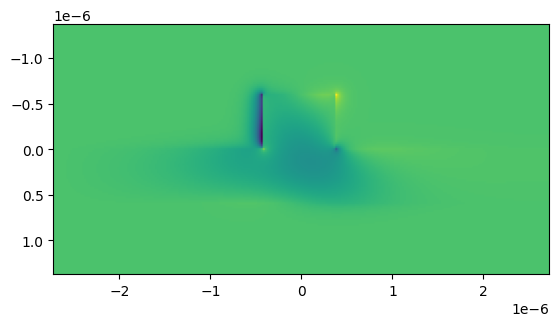

In [ ]:
ex_lin = np.reshape(Ex[:,0], (Nx, Ny), order='F')
plt.imshow(np.real(ex_lin.T), extent=np.array([xa.min(), xa.max(), ya.max(), ya.min()]), aspect="equal")

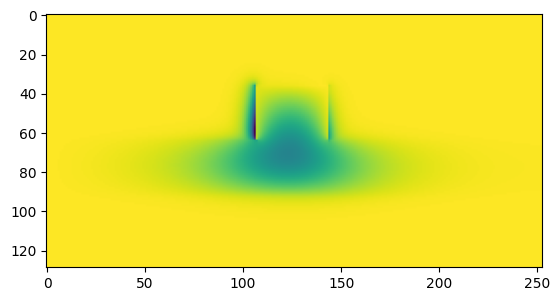

In [ ]:
ex = Ex[:, 1].reshape((Nx, Ny), order='F')
plt.imshow(np.real(ex.T))